# Домашнее задание №1 - Метод К-ближайших соседей (K-neariest neighbors)

Сегодня мы с вами реализуем наш первый алгоритм машинного обучения, метод К-ближайших соседей. Мы попытаемся решить с помощью него задачи:
- бинарной классификации (то есть, только двум классам)
- многоклассовой классификации (то есть, нескольким классам)
- регрессии (когда зависимая переменная - натуральное число)

Так как методу необходим гиперпараметр (hyperparameter) - количество соседей, то нам нужно научиться подбирать этот параметр. Мы постараемся научиться пользовать numpy для векторизованных вычислений, а также посмотрим на несколько метрик, которые используются в задачах классификации и регрессии.

Перед выполнением задания:
- установите все необходимые библиотеки, запустив `pip install -r requirements.txt`

Если вы раньше не работали с numpy или позабыли его, то можно вспомнить здесь:  
http://cs231n.github.io/python-numpy-tutorial/

In [1]:
import time
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
import pandas as pd

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from knn import KNNClassifier
from metrics import binary_classification_metrics, multiclass_accuracy

In [2]:
plt.rcParams["figure.figsize"] = 12, 9
sns.set_style("whitegrid")

SEED = 111
random.seed(SEED)
np.random.seed(SEED)

## Задание 1. KNN на датасете Fashion-MNIST (10 баллов)

В этом задании вам предстоит поработать с картинками одежды, среди которых можно выделить 10 классов. Данные уже загружены за вас: в переменной X лежат 70000 картинок размером 28 на 28 пикселей, вытянутые в вектор размерностью 784 (28 * 28). Так как данных довольно много, а наш KNN будет весьма медленный, то возьмем случайно 1000 наблюдений (в реальности в зависимости от вашей реализации можно будет взять больше, но если будет не зватать ОЗУ, то берите меньше).

In [3]:
X, y = fetch_openml(name="Fashion-MNIST", return_X_y=True, as_frame=False)

In [4]:
idx_to_stay = np.random.choice(np.arange(X.shape[0]), replace=False, size=1000)
X = X[idx_to_stay]
y = y[idx_to_stay]

Давайте посмотрим на какое-нибудь изображение из наших данных:

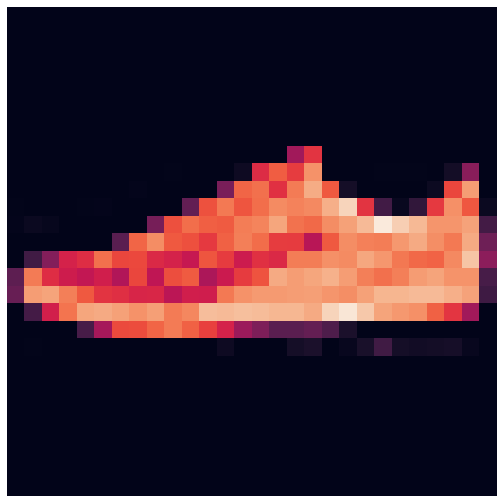

In [5]:
# возьмем случайную картинку и сделаем reshape
# 28, 28, 1 = H, W, C (число каналов, в данном случае 1)
image = X[np.random.choice(np.arange(X.shape[0]))].reshape(28, 28, 1)
plt.imshow(image)
plt.axis("off");

### 1.1. Посмотрим на все классы (0.5 баллов)

Возьмите по одной картинке каждого класса и изобразите их (например, сделайте subplots 5 на 2).

''

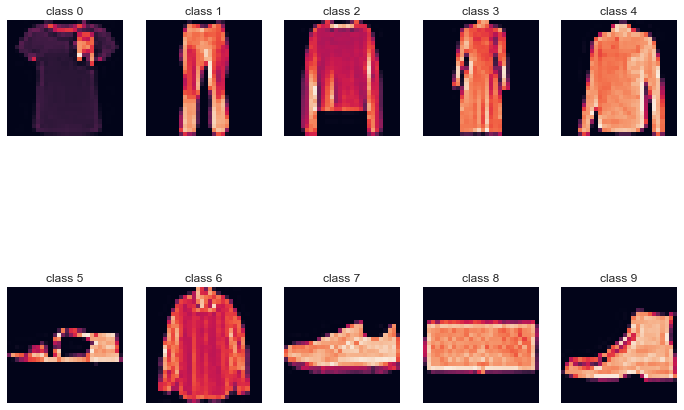

In [6]:
fig, axs = plt.subplots(nrows=2, ncols=5)

for ax, coord in zip(axs.flat, range(10)):
    for j in range(len(y)):
        if y[j] == str(coord):
            image = X[j].reshape(28, 28, 1)
            ax.imshow(image)
            ax.set_title(f'class {y[j]}')
            ax.axis("off")
            break
;

**Классы**

0. T-shirt/top
1. Trouser
2. Pullover
3. Dress
4. Coat
5. Sandal
6. Shirt
7. Sneaker
8. Bag
9. Ankle boot

### 1.2. Сделайте небольшой EDA (1 балл)

Посмотрите на баланс классов. В дальнейших домашках делайте EDA, когда считаете нужным, он нужен почти всегда, но оцениваться это уже не будет, если не будет указано иное. Делайте EDA, чтобы узнать что-то новое о данных!

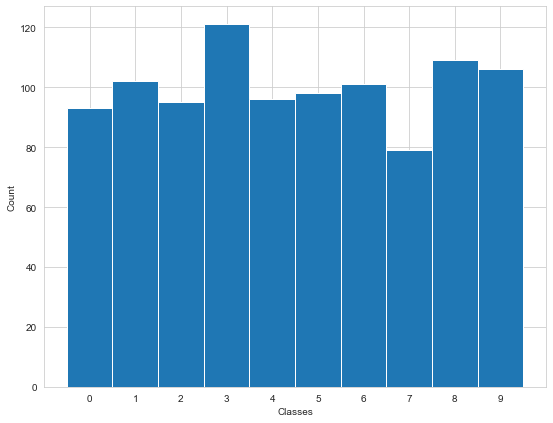

In [7]:
hist_class = sns.histplot(x=sorted(y), discrete=True, alpha=1)
hist_class.set_xlabel('Classes')
hist_class.figure.set_size_inches(9, 7);

*Все классы примерно сбалансированы*

In [8]:
print(X.dtype)
print(y.dtype)

float64
object


Для удобства, изменим тип эррэя `y` на числовой (integer):

In [9]:
y = y.astype(int)

### 1.3. Разделите данные на train и test (0.5 баллов)

Разделите данные на тренировочную и тестовую выборки, размеры тестовой выборки выберите сами. Здесь вам может помочь функция `train_test_split`

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

### 1.4. KNN для бинарной классификации (6 баллов)

Давайте возьмем для задачи бинарной классификации только объекты с метками классов 0 и 1.

Мне показалось удобнее вначале отобрать, а потом заново разделить на train и test. (Вроде в данном случае это ни на что не повлияет).

In [11]:
binary_y = y[y < 2]
binary_X = X[y < 2]

binary_train_X, binary_test_X, binary_train_y, binary_test_y = train_test_split(binary_X, binary_y, test_size=0.33)

Посмотрим на баланс классов в получившихся выборках (аналог EDA c гистограммой выше, но для бинарного случая).

In [12]:
pd.DataFrame({
    'train': [binary_train_y.shape[0], 
              np.count_nonzero(binary_train_y == 0), 
              round(np.count_nonzero(binary_train_y == 0) * 100 / binary_train_y.shape[0], 1)],
    'test': [binary_test_y.shape[0], 
              np.count_nonzero(binary_test_y == 0), 
              round(np.count_nonzero(binary_test_y == 0) * 100 / binary_test_y.shape[0], 1)]
}, index=['samples', 'num of class 0', 'class 0 percentage, %'])

,train,test
samples,130.0,65.0
num of class 0,59.0,34.0
"class 0 percentage, %",45.4,52.3


*Вроде более или менее сбалансированы (примерно пополам футболок и штанов)*

И вот мы подготовили данные, но модели у нас пока что нет. В нескольких занятиях нашего курса вам придется самостоятельно реализовывать какие-то алгоритмы машинного обучения, а потом сравнивать их с готовыми библиотечными решениями. В остальных заданиях реализовывать алгоритмы будет не обязательно, но может быть полезно, поэтому часто это будут задания на дополнительные баллы, но главное не это, а понимание работы алгоритма после его реализации с нуля на простом numpy. Также это все потом можно оформить в виде репозитория ml_from_scratch и хвастаться перед друзьями.

In [13]:
knn_classifier = KNNClassifier(k=1)
knn_classifier.fit(binary_train_X, binary_train_y)

### Настало время писать код!

В KNN нам нужно для каждого тестового примера найти расстояния до всех точек обучающей выборки. Допустим у нас 1000 примеров в train'е и 100 в test'е, тогда в итоге мы бы хотели получить матрицу попарных расстояний (например, размерностью 100 на 1000). Это можно сделать несколькими способами, и кому-то наверняка, в голову приходит идея с двумя вложенными циклами (надеюсь, что не больше:). Так можно делать, то можно и эффективнее. Вообще, в реальном KNN используется структура данных [k-d-tree](https://ru.wikipedia.org/wiki/K-d-%D0%B4%D0%B5%D1%80%D0%B5%D0%B2%D0%BE), которая позволяет производить поиск за log(N), а не за N, как будем делать мы (по сути это такое расширение бинарного поиска на многомерное пространство).

Вам нужно будет последовательно реализовать методы `compute_distances_two_loops`, `compute_distances_one_loop` и `compute_distances_no_loops` класса `KNN` в файле `knn.py`.

Эти функции строят массив расстояний между всеми векторами в тестовом наборе и в тренировочном наборе.  
В результате они должны построить массив размера `(num_test, num_train)`, где координата `[i][j]` соотвествует расстоянию между i-м вектором в test (`test[i]`) и j-м вектором в train (`train[j]`).

**Обратите внимание** Для простоты реализации мы будем использовать в качестве расстояния меру L1 (ее еще называют [Manhattan distance](https://ru.wikipedia.org/wiki/%D0%A0%D0%B0%D1%81%D1%81%D1%82%D0%BE%D1%8F%D0%BD%D0%B8%D0%B5_%D0%B3%D0%BE%D1%80%D0%BE%D0%B4%D1%81%D0%BA%D0%B8%D1%85_%D0%BA%D0%B2%D0%B0%D1%80%D1%82%D0%B0%D0%BB%D0%BE%D0%B2)).

$d_{1}(\mathbf {p} ,\mathbf {q} )=\|\mathbf {p} -\mathbf {q} \|_{1}=\sum _{i=1}^{n}|p_{i}-q_{i}|$

В начале я буду иногда писать разные assert'ы, чтобы можно было проверить правильность реализации, в дальнейшем вам нужно будет их писать самим, если нужно будет проверять корректность каких-то вычислений.

In [14]:
# TODO: compute_distances_two_loops
dists = knn_classifier.compute_distances_two_loops(binary_test_X)
assert np.isclose(dists[0, 100], np.sum(np.abs(binary_test_X[0] - binary_train_X[100])))

In [15]:
# TODO: compute_distances_one_loop
dists = knn_classifier.compute_distances_one_loop(binary_test_X)
assert np.isclose(dists[0, 100], np.sum(np.abs(binary_test_X[0] - binary_train_X[100])))

In [16]:
# TODO: compute_distances_no_loops
dists = knn_classifier.compute_distances_no_loops(binary_test_X)
assert np.isclose(dists[0, 100], np.sum(np.abs(binary_test_X[0] - binary_train_X[100])))

Проверим скорость работы реализованных методов

In [17]:
%timeit knn_classifier.compute_distances_two_loops(binary_test_X)
%timeit knn_classifier.compute_distances_one_loop(binary_test_X)
%timeit knn_classifier.compute_distances_no_loops(binary_test_X)

475 ms ± 3.51 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
43.2 ms ± 644 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
52.8 ms ± 1.63 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Реализуем метод для предсказания меток класса

In [18]:
# TODO: predict_labels_binary in knn.py
prediction = knn_classifier.predict(binary_test_X)

### Метрика

Теперь нужно реализовать несколько метрик для бинарной классификации. Не забудьте подумать о численной нестабильности (деление на 0).

In [19]:
# TODO: binary_classification_metrics in metrics.py

In [20]:
binary_classification_metrics(prediction, binary_test_y)

{'presicion': 0.96875,
 'recall': 1.0,
 'f1': 0.9841269841269841,
 'accuracy': 0.9846153846153847}

В целом это довольно хороший результат.

<img src="https://i.imgflip.com/406fu9.jpg" width="800" height="400">

**Проверка написаного кода методами из `sklearn.metrics`**

In [21]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

In [22]:
print('precision_score', precision_score(binary_test_y, prediction))
print('recall_score', recall_score(binary_test_y, prediction))
print('f1_score', f1_score(binary_test_y, prediction))
print('accuracy_score', accuracy_score(binary_test_y, prediction))

precision_score 0.96875
recall_score 1.0
f1_score 0.9841269841269841
accuracy_score 0.9846153846153847


*Всё сходится!*

**Тут я решила посмотреть, сколько картинок он определил неверно и каких:**

*(Из метрик понятно, что их точно немного)*

In [23]:
false_pred = prediction[binary_test_y != prediction]
false_pictures = binary_test_X[binary_test_y != prediction]
print(false_pred)

[1]


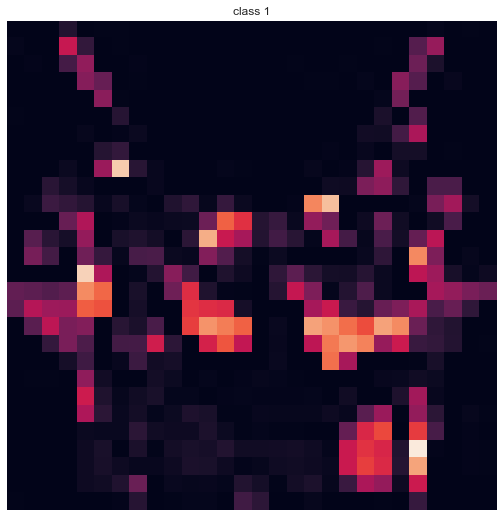

In [24]:
fig, axs = plt.subplots(nrows=1, ncols=false_pictures.shape[0])

if false_pred.shape[0] > 1:
    for ax, j in zip(axs.flat, range(false_pictures.shape[0])):
        ax.imshow((false_pictures[j].reshape(28, 28, 1)))
        ax.set_title(f'class {int(false_pred[j])}')
        ax.axis("off")
    ;
else:
    axs.imshow((false_pictures.reshape(28, 28, 1)))
    axs.set_title(f'class {int(false_pred)}')
    axs.axis("off")
    ;

*Это майка? В принципе, я тоже могу увидеть тут штаны*

**Проверка классификатора с помощью `sklearn.neighbors.KNeighborsClassifier`**

In [25]:
from sklearn.neighbors import KNeighborsClassifier

In [26]:
neigh = KNeighborsClassifier(n_neighbors=1, metric='manhattan')
neigh.fit(binary_train_X, binary_train_y)
real_pred = neigh.predict(binary_test_X)
np.array_equal(real_pred, prediction)

True

*Всё сошлось!*

### Подбор оптимального k

Чтобы подрбрать оптимальное значение параметра k можно сделать следующее: задать область допустимых значений k, например, `[1, 3, 5, 10]`. Дальше для каждого k обучить модель на тренировочных данных, сделать предсказания на тестовых и посчитать какую-нибудь метрику (метрику выберите сами исходя из задачи, но постарайтесь обосновать выбор). В конце нужно посмотреть на зависимость метрики на train'е и test'е от k и выбрать подходящее значение.

Реализуйте функцию `choose_best_k` прямо в ноутбуке.

In [27]:
def find_best_k(X_train, y_train, X_test, y_test, params, metric):
    """
    Choose the best k for KKNClassifier
    Arguments:
    X_train, np array (num_train_samples, num_features) - train data
    y_train, np array (num_train_samples) - train labels
    X_test, np array (num_test_samples, num_features) - test data
    y_test, np array (num_test_samples) - test labels
    params, list of hyperparameters for KNN, here it is list of k values
    metric, function for metric calculation
    Returns:
    train_metrics the list of metric values on train data set for each k in params
    test_metrics the list of metric values on test data set for each k in params
    """

    train_metrics = []
    test_metrics = []
    for k in params:
        tmp_classifier = KNNClassifier(k=k)
        tmp_classifier.fit(X_train, y_train)
        train_pred = tmp_classifier.predict(X_train)
        test_pred = tmp_classifier.predict(X_test)
        train_metrics.append(metric(y_train, train_pred)) # Use metrics from sklearn or change order in (y_true, y_pred)
        test_metrics.append(metric(y_test, test_pred)) # Use metrics from sklearn or change order in (y_true, y_pred)
    return train_metrics, test_metrics

In [28]:
params = range(1, 30)
train_metrics, test_metrics = find_best_k(binary_train_X, binary_train_y, binary_test_X, binary_test_y, params, accuracy_score)

Для оценки я решила использовать accuracy, потому что нету явного дисбаланса классов, а сам смысл accuracy мне понятнее, чем среднее гармоническое (?) precision и recall

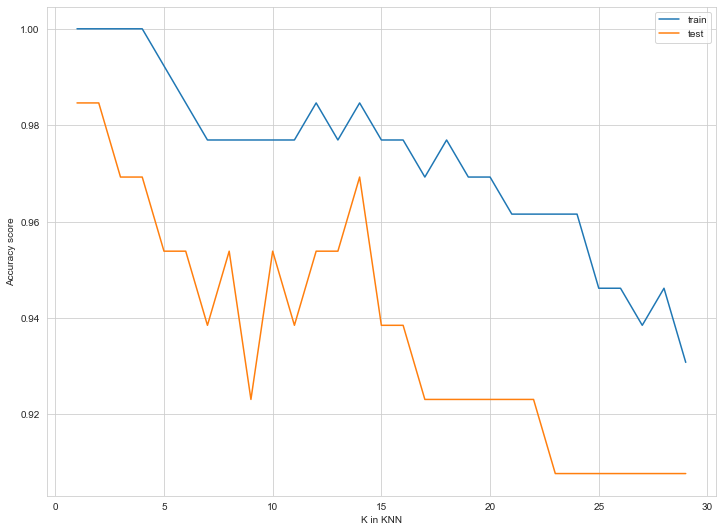

In [29]:
plt.plot(params, train_metrics, label="train")
plt.plot(params, test_metrics, label="test")
plt.legend()
plt.xlabel("K in KNN")
hist_class.set_xticks(range(0, 30))
plt.ylabel("Accuracy score");

На самом деле, это не самый лучший способ подбирать гиперпараметры, но способы получше мы рассмотрим в следующий раз, а пока что выберите оптимальное значение k, сделайте предсказания и посмотрите, насколько хорошо ваша модель предсказывает каждый из классов.

Лучше всего подходит `k=1` или `k=2` (модель для `k=1` реализована выше)

In [30]:
knn_classifier = KNNClassifier(k=2)
knn_classifier.fit(binary_train_X, binary_train_y)
prediction = knn_classifier.predict(binary_test_X)
binary_classification_metrics(prediction, binary_test_y)

{'presicion': 1.0,
 'recall': 0.967741935483871,
 'f1': 0.9836065573770492,
 'accuracy': 0.9846153846153847}

*precision и recall поменялись местами (точность выше, чувствительность ниже)*

### 1.5. Многоклассовая классификация (2 балла)

Теперь нужно научиться предсказывать все 10 классов. Для этого в начале напишем соответствующий метод у нашего классификатора.

In [31]:
# TODO: predict_labels_multiclass in knn.py
knn_classifier = KNNClassifier(k=1)
knn_classifier.fit(X_train, y_train)
predictions = knn_classifier.predict(X_test)

Осталось реализовать метрику качества для многоклассовой классификации, для этого реализуйте функцию `multiclass_accuracy` в `metrics.py`.

*Мой код:*

In [32]:
# TODO: multiclass_accuracy in metrics.py
multiclass_accuracy(predictions, y_test)

0.7454545454545455

*И проверка:*

In [33]:
accuracy_score(y_test, predictions)

0.7454545454545455

Интересно, какие классы предсказываются хуже остальных?

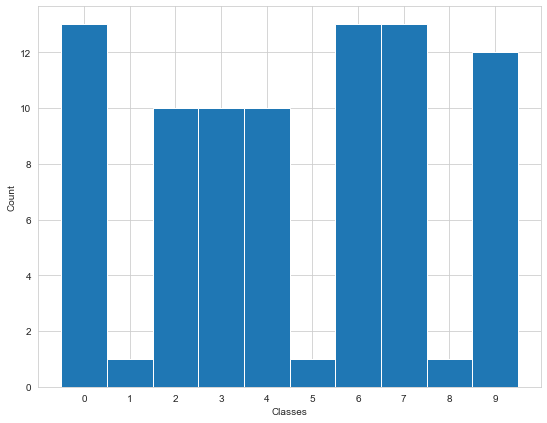

In [34]:
false_pred = predictions[y_test != predictions]
false_pictures = X_test[y_test != predictions]
hist_class = sns.histplot(x=sorted(false_pred), discrete=True, alpha=1)
hist_class.set_xlabel('Classes')
hist_class.set_xticks(range(0, 10))
hist_class.figure.set_size_inches(9, 7);

*Все неочень, кроме штанов, сандалий иии... Сумочек!*

Снова выберите оптимальное значение K как мы делали для бинарной классификации.

In [35]:
params = [1, 2, 3, 4, 5, 6, 8, 10, 15, 30]
train_metrics_multi, test_metrics_multi = find_best_k(X_train, y_train, X_test, y_test, params, accuracy_score)

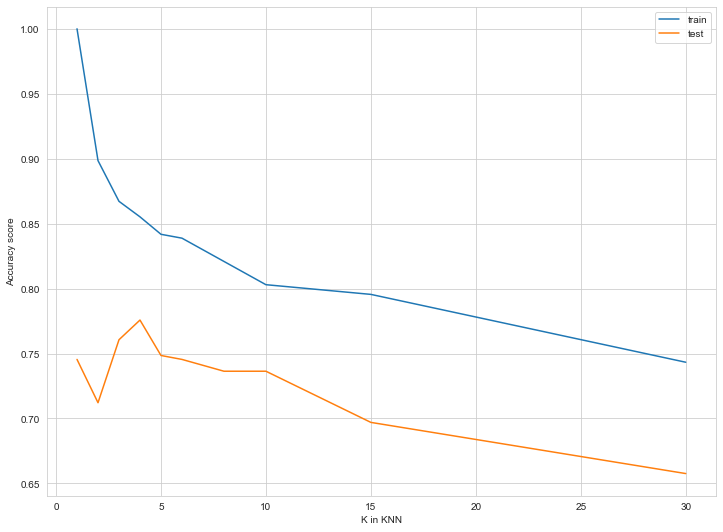

In [36]:
plt.plot(params, train_metrics_multi, label="train")
plt.plot(params, test_metrics_multi, label="test")
plt.legend()
plt.xlabel("K in KNN")
plt.ylabel("Accuracy score");

Хорошим явно выглядит k=4

In [37]:
knn_classifier = KNNClassifier(k=4)
knn_classifier.fit(X_train, y_train)
predictions = knn_classifier.predict(X_test)
multiclass_accuracy(predictions, y_test)

0.7757575757575758

*Аccuracy score немного улучшился*

Ещё один бесполезный хистплот:

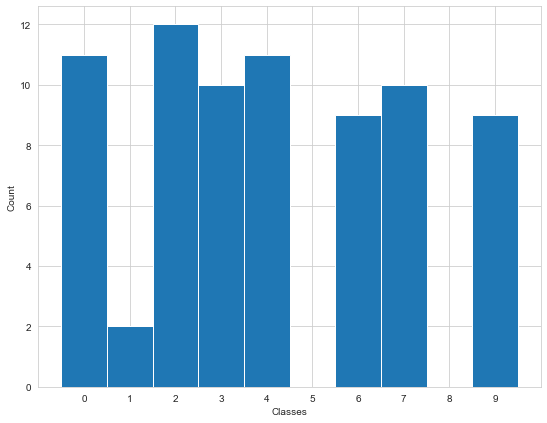

In [38]:
false_pred = predictions[y_test != predictions]
false_pictures = X_test[y_test != predictions]
hist_class = sns.histplot(x=sorted(false_pred), discrete=True, alpha=1)
hist_class.set_xlabel('Classes')
hist_class.set_xticks(range(0, 10))
hist_class.figure.set_size_inches(9, 7);

О, теперь в сандалиях и сумочках только сандали и сумочки! :)

## Задание 2. KNN на датасете diabetes (10 баллов)

Теперь попробуем применить KNN к задаче регрессии. Будем работать с [данными](https://scikit-learn.org/stable/datasets/toy_dataset.html#diabetes-dataset) о диабете. В этом задании будем использовать класс `KNeighborsRegressor` из библиотеки `sklearn`. Загрузим необходимые библиотеки:

In [39]:
from sklearn.datasets import load_diabetes
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor

In [40]:
X, y = load_diabetes(as_frame=True, return_X_y=True)

In [41]:
X.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641


### 2.1. EDA (2 обязательных балла + 2 доп. балла за Pipeline)

Сделайте EDA, предобработайте данные так, как считаете нужным, нужна ли в данном случае стандартизация и почему? Не забудте, что если вы стандартизуете данные, то нужно считать среднее и сдандартное отклонение на тренировочной части и с помощью них трансформировать и train, и test (**если не поняли это предложение, то обязательно разберитесь**).

**Дополнительно**:
Попробуйте разобраться с [`Pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html), чтобы можно было создать класс, который сразу проводит стандартизацию и обучает модель (или делает предсказание). Пайплайны очень удобны, когда нужно применять различные методы предобработки данных (в том числе и к разным столбцам), а также они позволяют правильно интегрировать предобработку данных в различные классы для поиска наилучших гиперпараметров модели (например, `GridSearchCV`).

In [42]:
from sklearn.pipeline import Pipeline

**Распределения предсказательных переменных**

''

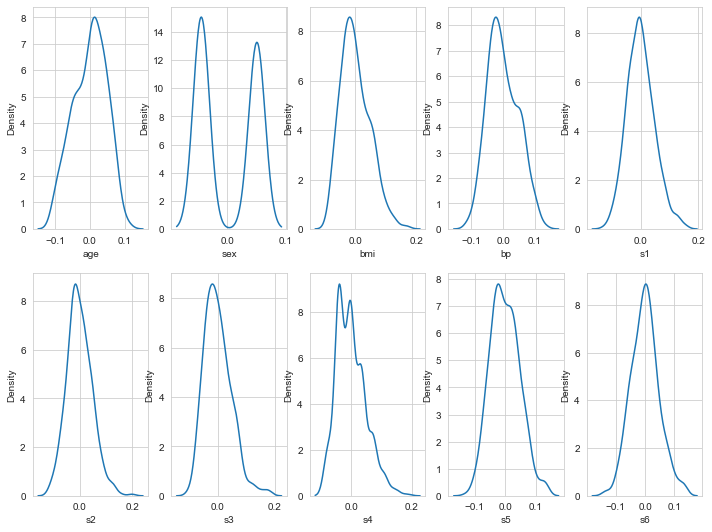

In [43]:
fig, axs = plt.subplots(nrows=2, ncols=5)


for ax, j in zip(axs.flat, X.columns):
    sns.kdeplot(X[j], ax=ax)
;

Согласно графикам выше, все переменные стандартизованы, а некоторые даже нормально распределены. Пол ожидаемо бимодален (потому что вообще бинарный по своей сути). Это подтверждается описанием датасета:

"Note: Each of these 10 feature variables have been mean centered and scaled by the standard deviation times n_samples (i.e. the sum of squares of each column totals 1)."

*Поэтому я решила ничего не стандартизовать, несмотря на то, что в данном случае стандартизация произошла до разделения на тренировочную и тестовую выборки*

**Распределение целевой переменной** 

(количественные скоры прогрессирования болезни спустя в течение года).

*А также я добавила групировку по полу и как оказалось, для обоих полов распределение похоже. Увы, я не нашла, какой пол зашифрован какой цифрой*

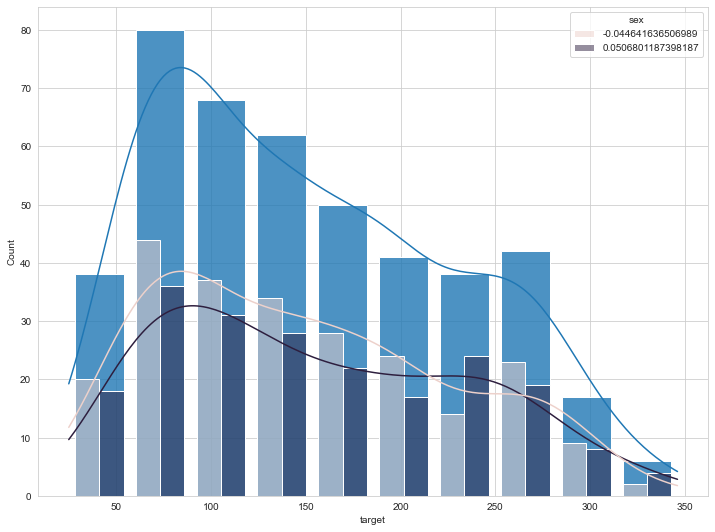

In [44]:
ax1 = sns.histplot(y, alpha=0.8, kde=True, shrink=0.8)
ax2 = sns.histplot(data=pd.concat([X, y], axis=1), x='target', hue='sex', kde=True, multiple="dodge", shrink=0.8)

**Типы данных в Х:**

In [45]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 442 entries, 0 to 441
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   age     442 non-null    float64
 1   sex     442 non-null    float64
 2   bmi     442 non-null    float64
 3   bp      442 non-null    float64
 4   s1      442 non-null    float64
 5   s2      442 non-null    float64
 6   s3      442 non-null    float64
 7   s4      442 non-null    float64
 8   s5      442 non-null    float64
 9   s6      442 non-null    float64
dtypes: float64(10)
memory usage: 34.7 KB


In [46]:
np.sum(X.isna())

age    0
sex    0
bmi    0
bp     0
s1     0
s2     0
s3     0
s4     0
s5     0
s6     0
dtype: int64

In [47]:
np.sum(X.isnull())

age    0
sex    0
bmi    0
bp     0
s1     0
s2     0
s3     0
s4     0
s5     0
s6     0
dtype: int64

**Типы данных в y:**

In [48]:
np.sum(X.isna())

age    0
sex    0
bmi    0
bp     0
s1     0
s2     0
s3     0
s4     0
s5     0
s6     0
dtype: int64

In [49]:
y.describe()

count    442.000000
mean     152.133484
std       77.093005
min       25.000000
25%       87.000000
50%      140.500000
75%      211.500000
max      346.000000
Name: target, dtype: float64

### 2.2. Регрессионная модель (1 балл)

Создайте модель `KNeighborsRegressor`, обучите ее на треноровочных данных и сделайте предсказания.

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
reg_knn = KNeighborsRegressor(n_neighbors=1)
reg_knn.fit(X_train, y_train)
pred_y = reg_knn.predict(X_test)

### 2.3. Метрики регресии (3 балла)

Реализуйте метрики $R^2$, MSE и  MAE в `metrics.py`. Примените их для оценки качества полученной модели. Все ли хорошо?

Напомню, что:

$R^2 = 1 - \frac{\sum_i^n{(y_i - \hat{y_i})^2}}{\sum_i^n{(y_i - \overline{y})^2}}$

$MSE = \frac{1}{n}\sum_i^n{(y_i - \hat{y_i})^2}$

$MAE = \frac{1}{n}\sum_i^n{|y_i - \hat{y_i}|}$

In [51]:
# TODO: r_squared, mse, mae in metrics.py

### 2.4. Подбор оптимального числа соседей (2 балла)

Мы почти дошли до конца. Теперь осталось при помощи реализованных нами метрик выбрать лучшее количество соседей для нашей модели.

!!! Обратите внимание на то, что значат наши метрики, для некоторых хорошо, когда они уменьшаются, для других наоборот.

**Метрики написаные мной**

In [52]:
from metrics import r_squared, mse, mae

print(f'r2 score: {r_squared(pred_y, y_test)}', 
      f'mean absolute error: {mae(pred_y, y_test)}', 
      f'mean squared error: {mse(pred_y, y_test)}', sep='\n')

r2 score: 0.12881941650467144
mean absolute error: 57.31506849315068
mean squared error: 5822.684931506849


**Метрики из `sklearn.metrics`**

In [53]:
print(r2_score(y_test, pred_y), mean_absolute_error(y_test, pred_y), mean_squared_error(y_test, pred_y), sep='\n')

0.12881941650467144
57.31506849315068
5822.684931506849


*Сходится!*

**Поиск лучшего k**

Немного изменила функцию `find_best_k_regr` для этого:

In [54]:
def find_best_k_regr(X_train, y_train, X_test, y_test, params, metric):
    train_metrics = []
    test_metrics = []
    for k in params:
        tmp_classifier = KNeighborsRegressor(n_neighbors=k)
        tmp_classifier.fit(X_train, y_train)
        train_pred = tmp_classifier.predict(X_train)
        test_pred = tmp_classifier.predict(X_test)
        train_metrics.append(metric(train_pred, y_train))
        test_metrics.append(metric(test_pred, y_test))
    return train_metrics, test_metrics

In [55]:
params = [1, 2, 3, 4, 5, 6, 8, 10, 15, 30]
train_metrics, test_metrics = find_best_k_regr(X_train, y_train, X_test, y_test, params, mse)

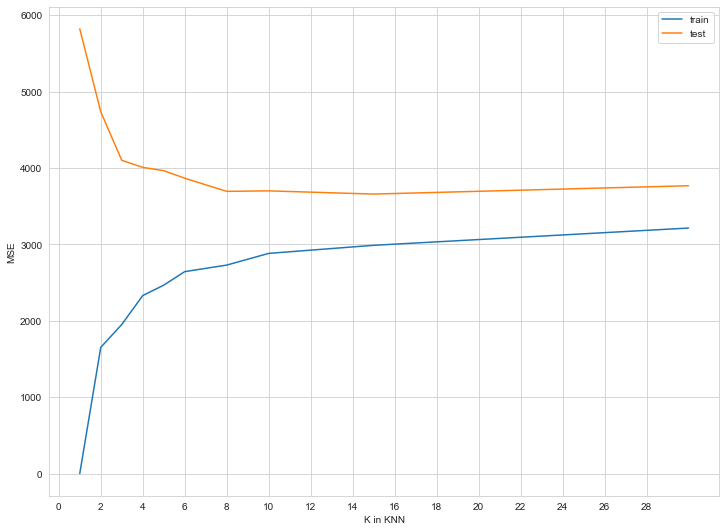

In [56]:
plt.plot(params, train_metrics, label="train")
plt.plot(params, test_metrics, label="test")
plt.legend()
plt.xticks(range(0, 30, 2))
plt.xlabel("K in KNN")
plt.ylabel("MSE");

И на MSE и на других метриках видно, что при k=8 происходит небольшой излом обоих графиков. В данном случае (MSE) после k=8 `test_metrics` уже почти не уменьшается, а `train_metrics`, наоборот, начинает увеличиваться быстрее.

In [57]:
reg_knn = KNeighborsRegressor(n_neighbors=8)
reg_knn.fit(X_train, y_train)
pred_y = reg_knn.predict(X_test)
print(f'r2 score: {r_squared(pred_y, y_test)}', 
      f'mean absolute error: {mae(pred_y, y_test)}', 
      f'mean squared error: {mse(pred_y, y_test)}', sep='\n')

r2 score: 0.44724485613881415
mean absolute error: 49.41438356164384
mean squared error: 3694.4338613013697


Видно, что сильно улучшился $R^2$ (ближе к 1) и сильно уменьшилась $MSE$

### 3. Социализация (0.5 доп. балла)

Так как у нас теперь большая группа, то было бы здорово всем познакомиться получше (так как выпускной не за горами). Соберитесь с одногруппниками в зуме (желательно, чтобы были люди и с Онлайна, и с Питера), познакомьтесь, а сюда прикрепите скриншот с камерами всех участников.

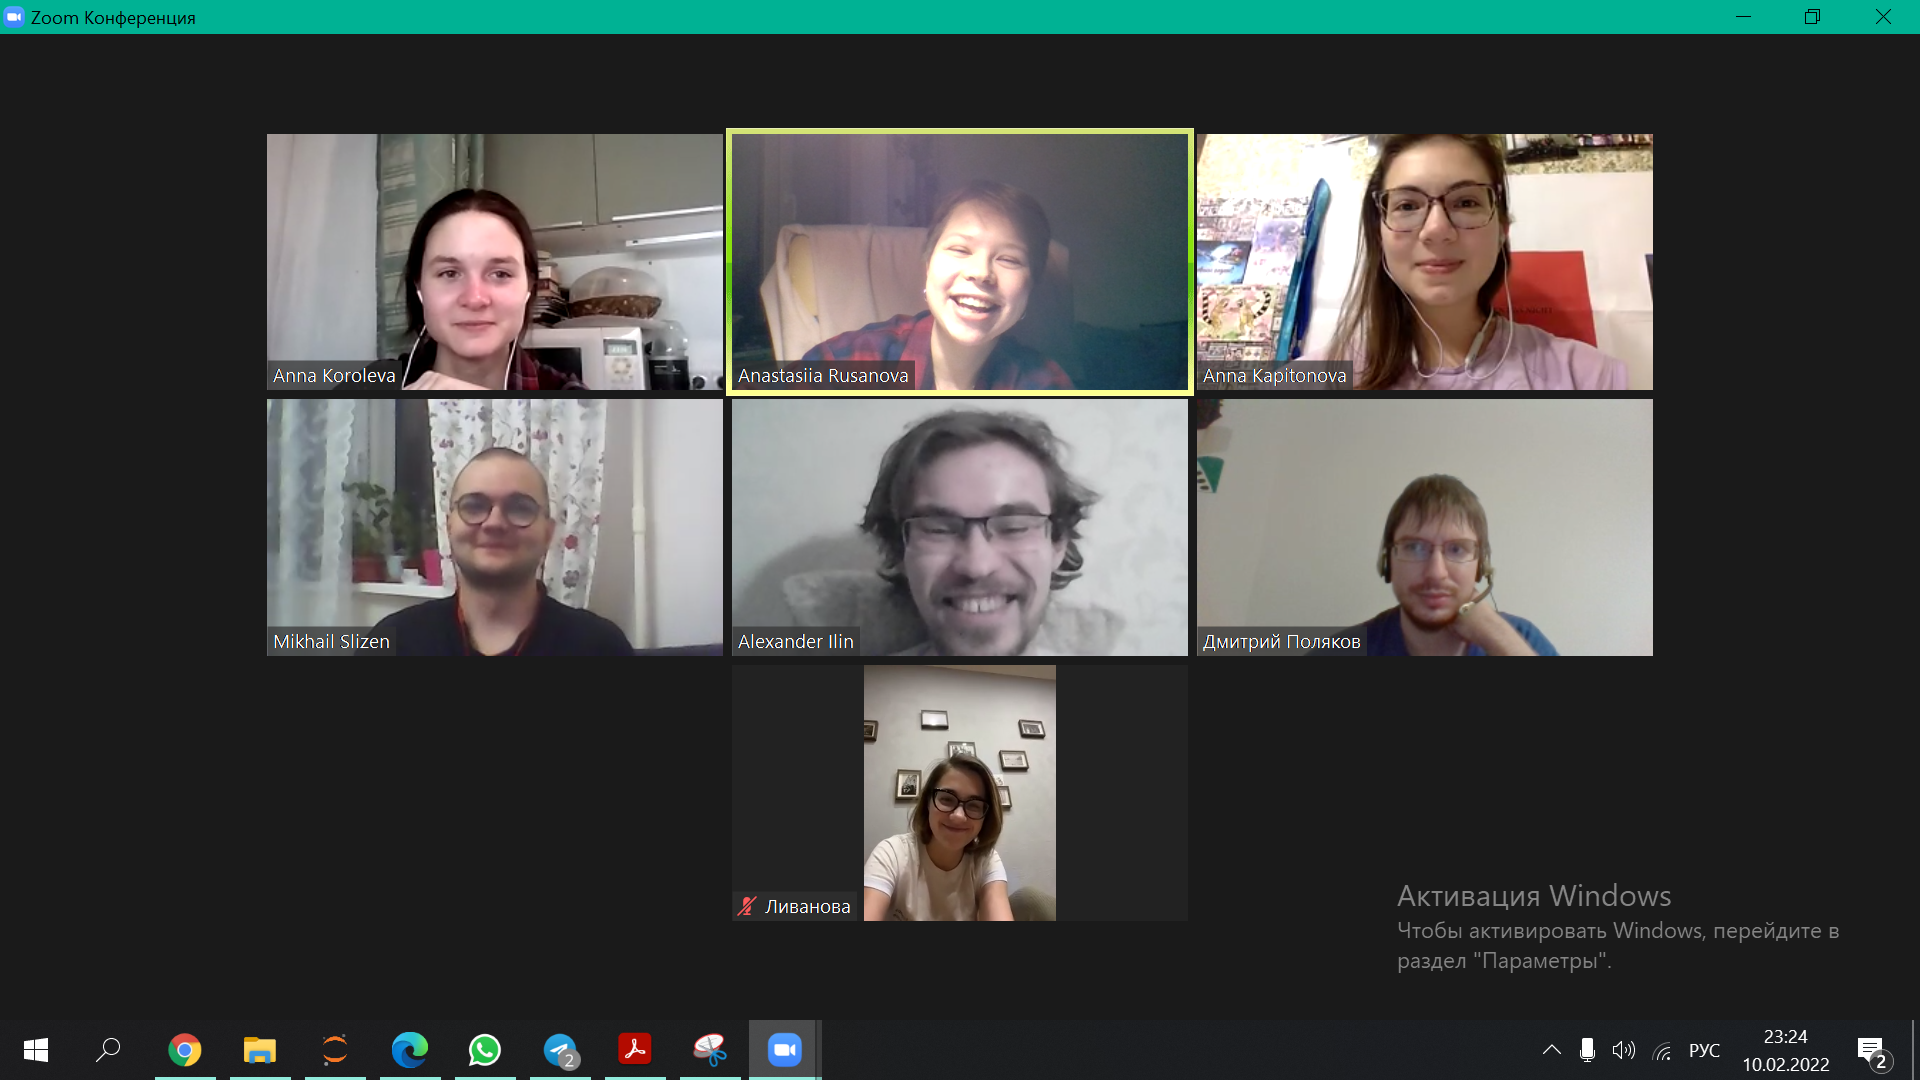

## Therapy time

Напишите здесь ваши впечатления о задании: было ли интересно, было ли слишком легко или наоборот сложно и тд. Также сюда можно написать свои идеи по улучшению заданий, а также предложить данные, на основе которых вы бы хотели построить следующие дз. 

**Ваши мысли:**

Я всё делаю в последний момент и не совсем успеваю подумать и написать :)

Но мне прямо очень понравилось работать в таком ноутбуке, гораздо приятнее, чем с нуля всё самой писать и тыкаться во всякие методы и алгоритмы вслепую. Самое сложное было осознать и написать матрицы дистанций (до сих пор не уверена, что правильно осознала третий способ), остальное действительно можно сделать за вечер.

Немного запутал порядок аргументов в метриках: в `metrics.py` вначале `y_pred`, потом `y_true` (а в sklearn всё наоборот). Но может это такая специальная уловка на внимательность :)